# Machine Learning (SST Patterns -> Eastern US Heatwaves)

# TODO
- [x] NCEP/NCAR Clustering & Heatwave Timeseries
- [x] Precursor MEAN/STD based on 60 Summer Days - Lag (instead of over entire series)
    - Does not make a difference :(
- [x] Cross-Correlation for Precursors, to find optimal Lags
- [ ] Add more precursor timeseries (Tropical Variability (OReilly, 2018), Soil Moisture (Google It, 2019))
- [ ] Correctly Number Precursor Regions (to allow for feature importances aggregate)
- [ ] Find Temporal Aggregation Optimum (Rolling Mean)
- [ ] Spatial Predictability (ROC/MSE for each gridcell in Eastern US)

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error

from skopt import gp_minimize
from skopt.utils import use_named_args, Real, Integer

import matplotlib.pyplot as plt

from functools import lru_cache
from concurrent.futures import ProcessPoolExecutor

import os

In [2]:
DATA_ROOT = os.path.abspath("../../data")

### Loaders and Plotting Functions

In [3]:
def load_heatwave_data(argument: str=None):
    # Load Heatwave Data from Disk
    df = pd.read_csv(os.path.join(DATA_ROOT, 'out/heatwave{}.csv'.format(f"_{argument}" if argument else "")), names=["date", "series"])
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"]) - pd.Timedelta(9, 'h')
    df = df.set_index("date")
    
    # Normalize Heatwave Data
    df = (df - df.mean()) / df.std()
    
    return df

def load_data(name, hours_offset=0):
    # Load SPI Data from Disk
    df = pd.read_csv(os.path.join(DATA_ROOT, f'out/{name}.csv'), names=["date", "series"])
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"]) + pd.Timedelta(hours_offset, 'h')
    df = df.set_index("date")
    
    return df


def load_spi_data():
    # Load SPI Data from Disk
    df = pd.read_csv(os.path.join(DATA_ROOT, 'out/spi.csv'))
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"])
    df = df.set_index("date")
    
    return df


def load_sst_precursor_data(year: int, lag: int):
    df = pd.read_csv(os.path.join(DATA_ROOT, 'patterns', f'{year}-{lag}.csv'))
    df['date'] = pd.DatetimeIndex(df['date']) - pd.Timedelta(9, 'h')
    df = df.set_index('date')
    return df


def load_sst_precursor_data_new(year: int, lag: int):
    df = pd.read_csv(os.path.join(DATA_ROOT, 'precursor', f'testyr[{year}]_{lag}.csv'))
    df['date'] = pd.DatetimeIndex(df['date']) - pd.Timedelta(9, 'h')
    df = df.set_index('date')
    
#     for column in df:
#         df[column] = (df[column] - df[column].mean()) / df[column].std()
    
    return df

@lru_cache(1)
def load_oni_data():
    df = pd.read_csv(os.path.join(DATA_ROOT, 'out', 'ONI.csv'), names=["date", "series"])
    
    # Set Date as Index
    df["date"] = pd.DatetimeIndex(df["date"]) - pd.Timedelta(9, 'h')
    df = df.set_index("date")
    
    return df


def plot_heatwave(heatwave: pd.Series, year: int, fit: pd.Series=None):
    # Working with Normalized Data
    heatwave_std = 1
    
    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot Heatwave
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(heatwave[str(year)], c="black", label="T95")
    plt.axhline(heatwave_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(heatwave[str(year)].index, heatwave_std, heatwave[str(year)],
                     where=heatwave[str(year)] > heatwave_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")
    
    # Plot Fit if Provided
    if fit is not None:
        plt.plot(fit[str(year)])

    plt.xlabel("Date")
    plt.ylabel("Heatwave (STD)")
    plt.ylim(-3, 3)
    plt.legend()
    plt.show()
    

def plot_roc(y_true: pd.DataFrame, y_predict: pd.DataFrame, threshold: float):
    # Make Square Plot
    plt.rcParams['figure.figsize'] = [5, 5]
    
    # Plot Receiver Operating Characteristic Curve with Area Under Curve Score
    fpr, tpr, thr = roc_curve(y_true > threshold, y_predict)
    auc = roc_auc_score(heatwave > threshold, y_predict)

    plt.title(f"ROC Curve - AUC: {auc:5.5f}")
    plt.plot([0, 1], [0, 1], linestyle="--", c="gray")
    plt.plot(fpr, tpr)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("False Positive Ratio")
    plt.ylabel("True Positive Ratio")
    

def plot_feature_importances(feature_importances_list):
    feature_importances = {}
    
    for feature_importance in feature_importances_list:
        for name, importance in feature_importance.items():
            if name not in feature_importances:
                feature_importances[name] = 0
            feature_importances[name] += importance
            
    names, importances = [], []
    
    for name, importance in feature_importances.items():
        names.append(name)
        importances.append(importance)
        
    importances = np.array(importances) / np.sum(importances)
    order = np.argsort(importances)
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.title(f"Relative Feature Importances")
    plt.barh(np.arange(len(names)), importances[order], tick_label=[names[index] for index in order])
    
    print([names[index] for index in order])
    print(importances[order])

### Heatwave Signals Plot

FileNotFoundError: File b'/Users/bram/Documents/Computational Science/Thesis/heatwave/data/out/heatwave.csv' does not exist

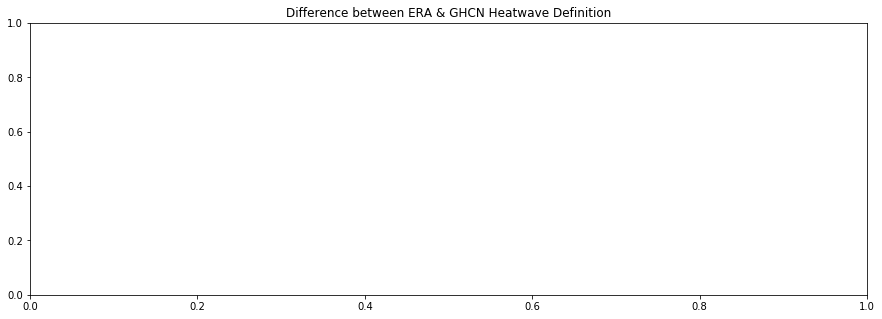

In [4]:
plot_year = 2012
plt.rcParams['figure.figsize'] = [15, 5]
plt.title("Difference between ERA & GHCN Heatwave Definition")
plt.plot(load_heatwave_data()[str(plot_year)], label="ERA")
plt.plot(load_heatwave_data("mean")[str(plot_year)], label="ERA MEAN")
plt.plot(load_heatwave_data("ghcn")[str(plot_year)], label="GHCN")
plt.xlabel("date")
plt.ylabel("heatwave (std)")
plt.legend()
plt.show()

In [ ]:
# Load Heatwave Data
heatwave = load_heatwave_data()

# Heatwave Threshold (Heatwave.mean + Heatwave.std = 1 (for normalized data))
heatwave_threshold = 1

YEARS = np.unique(heatwave.index.year)

plot_heatwave(heatwave['series'], 2012)

### Training/Optimization/Feature Functions

In [ ]:
# Feature Generation and Machine Learning Training
def train_test_split(features: pd.DataFrame, labels: pd.DataFrame, test_year: int, balance = 0.25):
    
    # Split Features and Labels based on Test Year
    train_x = pd.concat([features[str(year)] for year in YEARS if year != test_year])
    test_x = features[str(test_year)]

    train_y = pd.concat([labels[str(year)] for year in YEARS if year != test_year])
    test_y = labels[str(test_year)]
    
    if balance:

    # Balance Dataset
        pos = np.where(train_y > heatwave_threshold)[0]
        neg = np.where(train_y < heatwave_threshold)[0]

        # Balance Dataset
        # Idealy we would want to split pos/neg instances 50/50, but there's not enough data to do so
        idx = np.random.permutation(np.concatenate([pos, np.random.choice(neg, int(len(pos)/balance), False)]))

        return train_x.iloc[idx], train_y.iloc[idx], test_x, test_y
    else:
        return train_x, train_y, test_x, test_y
    
    
def train(regressor, features: pd.DataFrame, labels: pd.DataFrame, test_year: int, binary_y=False, importances=False):
    
    train_x, train_y, test_x, test_y = train_test_split(features, labels, test_year)
    
    # Fit Regressor to Data
    regressor.fit(train_x, train_y.values.ravel() > heatwave_threshold if binary_y else train_y.values.ravel())
    
    # Predict Heatwaves for Test Year
    prediction = pd.DataFrame(regressor.predict(test_x).reshape(-1, 1), index=test_y.index)
    
    if importances:
        feature_importances = {name: importance for name, importance in zip(features.columns, regressor.feature_importances_)}
        return test_y, prediction, feature_importances
    else:
        return test_y, prediction


def train_year(regressor, heatwave: pd.DataFrame, precursor_lag: int, lag: int, test_year: int, binary_y=False, importances=False):
    
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)
    
    # Transform Precursor Data into Features
    features = create_features(heatwave, precursor, lag)
    
    # Train Regressor with Features and Heatwave Data
    return train(regressor, features, heatwave, test_year, binary_y, importances)[1:]


def train_all(regressor, heatwave: pd.DataFrame, precursor_lag: int, lag: int, binary_y=False, importances=False):
    
    # Train for each Test Year (In Parallel)
    with ProcessPoolExecutor(4) as ex:
        
        # Run Train Year Function for Each Year in Parallel
        futures = [ex.submit(train_year, regressor, heatwave, precursor_lag, lag, test_year, binary_y, importances) for test_year in YEARS]
        
        # Obtain Results
        results = [future.result() for future in futures]
        
        # Wrap into Predictions DataFrame
        predictions = pd.DataFrame(np.concatenate([result[0] for result in results]), index=heatwave.index)
        
        if importances:
            feature_importances_list = [feature_importances for prediction, feature_importances in results]
            return predictions, feature_importances_list
        else:
            return predictions

def train_deviance_year(regressor, labels, precursor_lag, lag, test_year):
    # Load Precursor Data for Specific Lag and Test Year
    precursor = load_sst_precursor_data(test_year, precursor_lag)

    # Transform Precursor Data into Features
    features = create_features(labels, precursor, lag)

    train_x, train_y, test_x, test_y = train_test_split(features, labels, test_year)

    # Fit Regressor to Data
    regressor.fit(train_x, train_y.values.ravel())
    
    # Return Train Score & Test Score (MSE)
    return regressor.train_score_, [mean_squared_error(p, test_y) for p in regressor.staged_predict(test_x)]


def train_deviance(regressor, heatwave, precursor_lag, lag, plot=True):
    # Train for each Test Year (In Parallel)
    with ProcessPoolExecutor(4) as ex:
        
        # Run Train Year Function for Each Year in Parallel
        futures = [ex.submit(train_deviance_year, regressor, heatwave, precursor_lag, lag, test_year) for test_year in YEARS]
        
        train_scores = []
        test_scores = []
        
        # Obtain Results
        for train_mse, test_mse in [future.result() for future in futures]:
            train_scores.append(train_mse)
            test_scores.append(test_mse)
            
    train_scores = np.mean(train_scores, 0)
    test_scores = np.mean(test_scores, 0)
    
    opt_iterations = np.argmin(test_scores) + 1
    opt_score = np.min(test_scores)
    
    if plot:
        plt.rcParams['figure.figsize'] = [10, 5]
        plt.title(f"Gradient Boosting Regressor Performance over Iterations\n(Optimal Iterations: {opt_iterations}, Min MSE: {opt_score})")
        plt.plot(train_scores, label="Training Set Deviance")
        plt.plot(test_scores, label="Test Set Deviance")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance (MSE)")
        plt.legend()
        plt.savefig('deviance.png', dpi=300)
        plt.show()
    
    return opt_iterations, opt_score


def create_features(heatwave: pd.DataFrame, precursor: pd.DataFrame, lag: int):
    features = pd.DataFrame(index=heatwave.index)
    
    # Heatwave Timestamp minus 'lag' Days
    index = (heatwave.index - pd.Timedelta(lag, 'D'))
    
#     optima = {'spi': 69, 'sm2': 50, 'oni': 72, '2-average': 50, '2-covariance': 112, '3-average': 54, '3-covariance': 56, '4-average': 62, '4-covariance': 52, '5-average': 50, '5-covariance': 50, '6-average': 56, '6-covariance': 50, '7-average': 58, '7-covariance': 58, '8-average': 50, '8-covariance': 51, '11-average': 57, '11-covariance': 61, '13-average': 94, '13-covariance': 65, '10-average': 50, '10-covariance': 91, '1-average': 50, '1-covariance': 50}
    
#     features[f"spi"] = load_spi_data()["50"][index].values
    
#     features["sm1"] = load_data("SM1_05", -9).loc[index].values
#     features["sm2"] = load_data("SM2_05", -9).loc[index].values
    features["sm3"] = load_data("SM3_05").loc[index].values
#     features["st1"] = load_data("ST1_95").loc[index].values
#     features["st2"] = load_data("ST2_95").rolling(14).mean().loc[index].values
    features["nao"] = load_data("NAO").rolling(30).mean().loc[index].values
    features["pna"] = load_data("PNA").rolling(30).mean().loc[index].values
    features["oni"] = load_oni_data().loc[heatwave.index - pd.Timedelta(75, "D")].values
    
    # Sea Surface Temperature Patterns (Sem)
    for column in precursor.columns:
        if column in ['2-average', '3-average', '4-average', '7-average']:
#         if 'average' in column:
            features[f"{column}"] = precursor[column][index].values
    
#     if '4-average' in precursor.columns and '2-average' in precursor.columns:
#         features["2-4"] = precursor['4-average'][index].values * precursor['2-average'][index].values
#     if '2-average' in precursor.columns and '3-average' in precursor.columns:
#         features["2-3"] = precursor['3-average'][index].values * precursor['2-average'][index].values
            
    return features

In [ ]:
# PRECURSOR_LAG = 0
# LAG_RANGE = range(0, 120, 1)

# correlations = []

# for lag in LAG_RANGE:
    
#     correlation = {}
    
#     for test_year in YEARS:
        
#         print(f"\rCalculating Cross Correlation for lag {lag} & year {test_year}", end="")
        
#         precursor = load_sst_precursor_data(test_year, PRECURSOR_LAG)
#         features = create_features(heatwave, precursor, lag)
        
#         for column in features.columns:
#             if column not in correlation: correlation[column] = []
#             correlation[column].append(np.cov(features[column].values.ravel(), heatwave.values.ravel())[0, 1])
            
#     correlations.append({column: np.mean(corrs) for column, corrs in correlation.items()})

In [ ]:
# LAG_MIN = 50
# LAG_MIN_INDEX = LAG_MIN // LAG_RANGE.step

# correlation_features = []
# correlation_series = []

# for feature in correlations[0].keys():
#     correlation_features.append(feature)
#     correlation_series.append(np.array([correlation[feature] for correlation in correlations]))
    
# correlation_optimum_lag = [LAG_RANGE[LAG_MIN_INDEX + np.argmax(np.abs(corr[LAG_MIN_INDEX:]))] for corr in correlation_series]

# order = np.argsort(np.mean(np.abs(correlation_series), 1))[::-1]

# plt.rcParams['figure.figsize'] = [25, 10]

# print({feature: optimum for feature, optimum in zip(correlation_features, correlation_optimum_lag)})

# for index in order:
#     plt.plot(LAG_RANGE, np.abs(correlation_series[index]), label=f"{correlation_features[index]} -> {correlation_optimum_lag[index]}")

# plt.title("Feature Cross Correlation over Lags")
# plt.xlabel("lag")
# plt.ylabel("Cross Correlation")
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
PRECURSOR_LAG = 0
LAG = 50

spatcov_all = pd.DataFrame(index=heatwave.index, columns=["values"])

for year in np.unique(heatwave.index.year):
    index = heatwave[str(year)].index
    spatcov = load_sst_precursor_data_new(year, PRECURSOR_LAG)['spatcov_CPPA'][index  - pd.Timedelta(LAG, 'D')]
    
    spatcov_all["values"][index] = spatcov.values.ravel()

roc_auc_score(heatwave > heatwave_threshold, spatcov_all)

In [ ]:
plot_heatwave(heatwave=heatwave['series'], fit=spatcov_all, year=2009)

In [ ]:
LEARNING_RATE = 0.005
SUBSAMPLE = 1
MAX_DEPTH = 3
PRECURSOR_LAG = 0
LAG = 50

# Optimize Gradient Boosting Regressor by Looking at Train/Test Deviance at all Boosting Iterations
regressor = GradientBoostingRegressor(n_estimators=int(4.0/LEARNING_RATE), max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE, subsample=SUBSAMPLE)
N_ESTIMATORS, MIN_MSE = train_deviance(regressor, heatwave, precursor_lag=PRECURSOR_LAG, lag=LAG)

# Train Optimized Gradient Boosting Regressor and Generate Predictions for Entire Heatwave Series
regressor = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE, subsample=SUBSAMPLE)
predictions, feature_importances = train_all(regressor, heatwave, precursor_lag=PRECURSOR_LAG, lag=LAG, importances=True)

# Plot Receiver Operating Characteristic (ROC) Curve & Feature Importances
plt.subplot(121); plot_feature_importances(feature_importances)
plt.subplot(122); plot_roc(heatwave, predictions, heatwave_threshold)
plt.savefig('eval.png', dpi=300)
plt.show()

# # Plot ROC AUC Confidence Interval
# roc_auc_scores = []
# for i in range(20):
#     regressor = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, learning_rate=LEARNING_RATE)
#     predictions, feature_importances = train_all(regressor, heatwave, precursor_lag=PRECURSOR_LAG, lag=LAG)
#     roc_auc_scores.append(roc_auc_score(heatwave > heatwave_threshold, predictions))
    
#     # Display Statistics
#     mean, std = np.mean(roc_auc_scores), np.std(roc_auc_scores)
#     print(f"\r[{i+1:02d}] ROC AUC 95% confidence interval: [{mean-2*std}, {mean+2*std}]", end="")

In [ ]:
PRECURSOR_LAG = 0
LAG = 50

# Train Optimized Gradient Boosting Regressor and Generate Predictions for Entire Heatwave Series
regressor = AdaBoostRegressor(n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, loss='square')
predictions, feature_importances = train_all(regressor, heatwave, precursor_lag=PRECURSOR_LAG, lag=LAG, importances=True)

# Plot Receiver Operating Characteristic (ROC) Curve & Feature Importances
plt.subplot(121); plot_feature_importances(feature_importances)
plt.subplot(122); plot_roc(heatwave, predictions, heatwave_threshold)
plt.savefig('eval.png', dpi=300)
plt.show()

In [ ]:
from sklearn.svm import SVR, NuSVR

PRECURSOR_LAG = 0
LAG = 50

regressor = NuSVR(kernel='rbf', gamma='auto', nu=0.4)
predictions = train_all(regressor, heatwave, precursor_lag=PRECURSOR_LAG, lag=LAG)

# Plot Receiver Operating Characteristic (ROC) Curve & Feature Importances
plot_roc(heatwave, predictions, heatwave_threshold)
plt.show()

In [ ]:
from sklearn.linear_model import SGDRegressor

PRECURSOR_LAG = 0
LAG = 50

regressor = SGDRegressor(tol=1E-3)
predictions = train_all(regressor, heatwave, precursor_lag=PRECURSOR_LAG, lag=LAG)

# Plot Receiver Operating Characteristic (ROC) Curve & Feature Importances
plot_roc(heatwave, predictions, heatwave_threshold)
plt.show()

In [ ]:
plot_heatwave(heatwave=heatwave['series'], fit=predictions, year=2011)

In [ ]:
old = load_sst_precursor_data(2012, 0)
old = pd.concat([old[column] for column in old.columns if 'average' in column], axis=1)
new = load_sst_precursor_data_new(2012, 0)

print(old['2-average'].std(), new['2.0'].std())
print(old['3-average'].std(), new['4.0'].std())

time_span = "2012"

plt.title(f"Precursor Region 2 (US West Coast) OLD vs NEW in {time_span}")
plt.plot((old['2-average'] / old['2-average'].std())[time_span], label='old')
plt.plot((new['2.0'] / new['2.0'].std())[time_span], label='new')
plt.legend()
plt.show()

plt.title(f"Precursor Region 4 (caribbean) OLD vs NEW in {time_span}")
plt.plot((old['3-average'] / old['3-average'].std())[time_span], label='old')
plt.plot((new['4.0'] / new['4.0'].std())[time_span], label='new')
plt.legend()
plt.show()